$\mathcal{D} = {(\mathbf{k}_1, \mathbf{v}_1),...,(\mathbf{k}_m, \mathbf{v}_m)}$ is the database of key-valute pairs, $\mathbf{q}$ is the query:

$
\text{Attention}(\mathbf{q}, \mathcal{D}) 
\overset{\text{def}}{=} 
\sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
$

$\alpha(\mathbf{q}, \mathbf{k}_i)$ is the attention weight (usually computed via a similarity or alignment function).

You can pick any function $a(\mathbf{q}, \mathbf{k})$ and then defines the attention weight as a softmax-normalized similarity between the query and key:
$
\alpha(\mathbf{q}, \mathbf{k}_i) = 
\frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{
\sum_{j} \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$


![attention polling](./Images/attentionPolling1.png)

In [2]:
import torch
from d2l import torch as d2l

In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

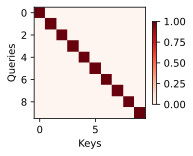

In [5]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

========================Attention Pooling by Similarity=========================

In [6]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

similarity kernels from the kernel smoothing / density estimation family

1. **Gaussian kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right)
$

2. **Boxcar (Uniform) kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) =
\begin{cases}
1, & \text{if } \|\mathbf{q} - \mathbf{k}\| \le 1 \\
0, & \text{otherwise}
\end{cases}
$

3. **Epanechnikov kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \max(0, 1 - \|\mathbf{q} - \mathbf{k}\|)
$

All the kernels  defined in this section are translation and rotation invariant; that is, if we shift and rotate $\mathbf{k}$ and $\mathbf{q}$ in the same manner, the value of $\alpha(\mathbf{q}, \mathbf{k})$ remains unchanged. For simplicity we thus pick scalar arguments $\mathbf{k}, \mathbf{q} \in \mathbb{R}^d$ and pick the key $\mathbf{k}$ = 0 as the origin. This yields:


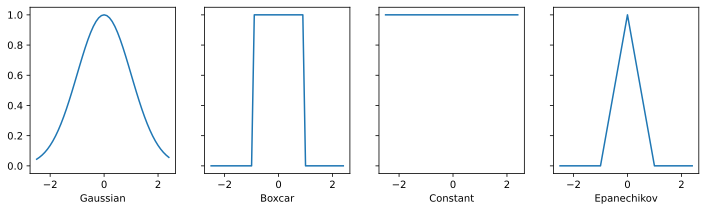

In [7]:

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

In [8]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
# torch.rand generates uniform random numbers in [0, 1)
# torch.randn generates standard normal random numbers with mean 0 and variance 1
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

x_train, y_train, x_train.shape, y_train.shape, x_val.shape, y_val.shape

(tensor([0.0722, 0.2513, 0.3017, 0.3553, 0.4479, 0.6568, 0.7535, 0.8691, 1.0899,
         1.1063, 1.3183, 1.6613, 1.9180, 2.0276, 2.1144, 2.2678, 2.2875, 2.2956,
         2.3035, 2.3281, 2.3779, 2.3826, 3.0371, 3.0392, 3.1192, 3.1262, 3.3359,
         3.4079, 3.4429, 3.4908, 3.8666, 3.9956, 4.1477, 4.2427, 4.2533, 4.3894,
         4.3979, 4.5221, 4.6605, 4.9540]),
 tensor([-0.1054,  0.2434, -0.2743,  2.0069,  1.1093,  2.6754,  1.3477,  2.7350,
          3.0172,  3.4602,  4.3651,  2.7643,  1.9115,  4.3816,  2.7617,  6.0798,
          3.5418,  5.1783,  3.8382,  4.2797,  2.4419,  1.3285,  2.0407,  3.2100,
          3.2548,  2.7915,  2.7249,  4.0634,  2.4250,  1.6364,  4.2562,  3.0562,
          2.7649,  3.8122,  0.1543,  0.6970,  0.8427,  3.1988,  0.6137,  3.9957]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([50]),
 torch.Size([50]))

 Attention Pooling via Nadaraya–Watson Regression

In [9]:
#  each validation feature be a query
#  each training feature–label pair be a key–value pair.
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # x_train.reshape((-1, 1)): (num_train, 1)
    # x_val.reshape((1, -1)): (1, num_val)
    # dists.shape: (num_train, num_val)
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    # k.shape: (num_train, num_val)
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

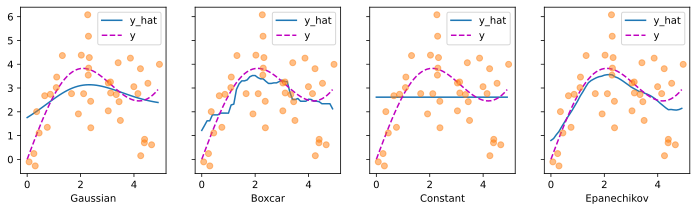

In [10]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

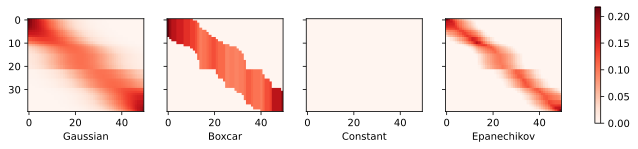

In [11]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

=============================Attention Scoring Functions=======================

![attention polling with softmax](./Images/attentionPollingSoftmax.png)

In [12]:
import math
import torch
from torch import nn
from d2l import torch as d2l

scaled dot product attention scoring function

$
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}.
$

$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i))
= \frac{\exp\left(\frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}\right)}
{\sum_{j=1}^{n} \exp\left(\frac{\mathbf{q}^\top \mathbf{k}_j}{\sqrt{d}}\right)}.
$


In [13]:
# masked softmax operation.

from operator import add

# Note: look at last few lines, it will reshape x to 2D tensor, valid_lens to 1D tensor.
# After apply masking, it will reshape x back to original shape.

def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        print("valid_len:", valid_len)
        # dimension 1's length
        maxlen = X.size(1)

        # x[:, None] and x[None, :] add a new dimension to a tensor using `None` (equivalent to `np.newaxis`).
        # x[:, None] → Adds dimension at position 1 (after first dimension)
        # x[None, :] → Adds dimension at position 0 (before first dimension)

        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            # Repeat the first dimension of valid_lens by shape[1] times
            valid_lens = torch.repeat_interleave(input = valid_lens, repeats = shape[1])
        else:
            # flatten to 1D tensor
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [14]:
# x[:, None] and x[None, :] add a new dimension to a tensor using `None` (equivalent to `np.newaxis`).
# x[:, None] → Adds dimension at position 1 (after first dimension)
# x[None, :] → Adds dimension at position 0 (before first dimension)

x = torch.rand(2, 2, 4)
y = x[:,None]
z = x[None,:]  
x, y, z, x.shape, y.shape, z.shape

(tensor([[[0.6117, 0.3143, 0.4387, 0.3064],
          [0.4230, 0.7799, 0.0106, 0.2586]],
 
         [[0.6696, 0.7172, 0.3308, 0.8638],
          [0.7344, 0.9529, 0.7117, 0.7337]]]),
 tensor([[[[0.6117, 0.3143, 0.4387, 0.3064],
           [0.4230, 0.7799, 0.0106, 0.2586]]],
 
 
         [[[0.6696, 0.7172, 0.3308, 0.8638],
           [0.7344, 0.9529, 0.7117, 0.7337]]]]),
 tensor([[[[0.6117, 0.3143, 0.4387, 0.3064],
           [0.4230, 0.7799, 0.0106, 0.2586]],
 
          [[0.6696, 0.7172, 0.3308, 0.8638],
           [0.7344, 0.9529, 0.7117, 0.7337]]]]),
 torch.Size([2, 2, 4]),
 torch.Size([2, 1, 2, 4]),
 torch.Size([1, 2, 2, 4]))

In [15]:
x = torch.rand(2, 2, 4)
x, masked_softmax(x, torch.tensor([2, 3]))

valid_len: tensor([2, 2, 3, 3])


(tensor([[[ 8.1610e-01,  7.3916e-01, -1.0000e+06, -1.0000e+06],
          [ 2.6157e-01,  5.3298e-01, -1.0000e+06, -1.0000e+06]],
 
         [[ 5.5594e-01,  2.7265e-01,  4.7620e-01, -1.0000e+06],
          [ 9.6525e-01,  2.5180e-02,  2.1348e-01, -1.0000e+06]]]),
 tensor([[[0.5192, 0.4808, 0.0000, 0.0000],
          [0.4326, 0.5674, 0.0000, 0.0000]],
 
         [[0.3736, 0.2814, 0.3450, 0.0000],
          [0.5370, 0.2098, 0.2532, 0.0000]]]))

In [16]:
# If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we simply use a two-dimensional tensor of valid lengths. 

x, masked_softmax(x, torch.tensor([[1, 3], [2, 4]]))

valid_len: tensor([1, 3, 2, 4])


(tensor([[[ 8.1610e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
          [ 2.6157e-01,  5.3298e-01, -1.0000e+06, -1.0000e+06]],
 
         [[ 5.5594e-01,  2.7265e-01, -1.0000e+06, -1.0000e+06],
          [ 9.6525e-01,  2.5180e-02,  2.1348e-01, -1.0000e+06]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4326, 0.5674, 0.0000, 0.0000]],
 
         [[0.5704, 0.4296, 0.0000, 0.0000],
          [0.5370, 0.2098, 0.2532, 0.0000]]]))

In [17]:
x, masked_softmax(x, None)

(tensor([[[ 8.1610e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
          [ 2.6157e-01,  5.3298e-01, -1.0000e+06, -1.0000e+06]],
 
         [[ 5.5594e-01,  2.7265e-01, -1.0000e+06, -1.0000e+06],
          [ 9.6525e-01,  2.5180e-02,  2.1348e-01, -1.0000e+06]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4326, 0.5674, 0.0000, 0.0000]],
 
         [[0.5704, 0.4296, 0.0000, 0.0000],
          [0.5370, 0.2098, 0.2532, 0.0000]]]))

Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values.
More specifically, assume that

$
\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b},
\quad
\mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c}.
$

$
\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n]
\in \mathbb{R}^{n \times a \times c}.
$


In [18]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Scaled Dot Product Attention

The scaled dot-product attention of queries
$\mathbf{Q} \in \mathbb{R}^{n \times d}$, keys $\mathbf{K} \in \mathbb{R}^{m \times d}$, and values $\mathbf{V} \in \mathbb{R}^{m \times v}$ can be written as
$\text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} \right) \mathbf{V} \in \mathbb{R}^{n \times v}$


In [19]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [20]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


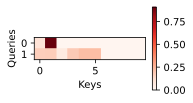

In [21]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimension, we can either use a matrix to address the mismatch via $\mathbf{q}^\top\mathbf{M}\mathbf{k}$,
 or we can use additive attention as the scoring function, Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. Given a query $\mathbf{q} \in \mathbb{R}^{q}$ and a key $\mathbf{k} \in \mathbb{R}^{k}$  the additive attention scoring function is given by:

$
a(\mathbf{q}, \mathbf{k}) = \mathbf{w}_v^\top 
\tanh\left( \mathbf{W}_q \mathbf{q} + \mathbf{W}_k \mathbf{k} \right)
\in \mathbb{R},
$
where $\mathbf{W}_q \in \mathbb{R}^{h \times q}$, $\mathbf{W}_k \in \mathbb{R}^{h \times k}$, and $\mathbf{w}_v \in \mathbb{R}^{h}$ are learnable parameters.




In [22]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(out_features = num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(out_features = num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(out_features = 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # queries: (batch_size, no. of queries, query dimension)
        # keys: (batch_size, no. of key-value pairs, key dimension)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries: (batch_size, no. of queries, 1, num_hiddens)
        #keys: (batch_size, 1, no. of key-value pairs, num_hiddens)

        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # features shape: (batch_size, no. of queries, no. of key-value pairs, num_hiddens)

        features = torch.tanh(features)

        # self.w_v(features): (batch_size, no. of queries, no. of key-value pairs, 1)
        scores = self.w_v(features).squeeze(-1)
        # Shape of scores: (batch_size, no. of queries, no. of key-value pairs)

        self.attention_weights = masked_softmax(scores, valid_lens)

        # Shape of return values: (batch_size, no. of key-value pairs, value dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


c:\Users\huiya\pytorch-basics\.venv311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


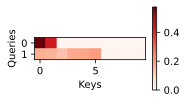

In [24]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In this section we introduced the two key attention scoring functions: dot product and additive attention. They are effective tools for aggregating across sequences of variable length. In particular, the dot product attention is the mainstay of modern Transformer architectures. When queries and keys are vectors of different lengths, we can use the additive attention scoring function instead. Optimizing these layers is one of the key areas of advance in recent years.

=======================The Bahdanau Attention Mechanism=========================

Conventionally, in an RNN all relevant information about a source sequence is translated into some internal fixed-dimensional state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

![statePassedfromEncoderToDecoder](./Images/statePassedfromEncoderToDecoder.png)

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough “space” in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences

Bahdanau et al. (2014) proposed a differentiable attention model without the unidirectional alignment limitation.
**When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction.** This is then used to update the current state before generating the next token. While quite innocuous in its description, this Bahdanau attention mechanism has arguably turned into one of the most influential ideas of the past decade in deep learning, giving rise to Transformers (Vaswani et al., 2017) and many related new architectures.

![BahdanauAttention](./Images/BahdanauAttention.png)

In [25]:
import torch
from torch import nn
from d2l import torch as d2l

Comprehensive explanation of x[-1], x[:, -1], and x[:, :, -1]

In [26]:
print("=== Understanding Negative Indexing in 2D and 3D Tensors ===")
print()

# Create sample 2D tensor
print("📊 2D TENSOR EXAMPLE:")
x_2d = torch.tensor([[1, 2, 3, 4],
                     [5, 6, 7, 8],
                     [9, 10, 11, 12]])
print(f"x_2d shape: {x_2d.shape}")  # (3, 4)
print(f"x_2d:\n{x_2d}")
print()

print("2D Tensor Indexing:")
print(f"x_2d[-1]:       {x_2d[-1]} \t\t Shape: {x_2d[-1].shape}")
print(f"x_2d[:, -1]:    {x_2d[:, -1]} \t\t\t Shape: {x_2d[:, -1].shape}")
print("x_2d[:, :, -1]: ❌ ERROR - 2D tensor only has 2 dimensions!")
print()

# Create sample 3D tensor  
print("📦 3D TENSOR EXAMPLE:")
x_3d = torch.tensor([[[1, 2, 3, 4],
                      [5, 6, 7, 8]],
                     
                     [[9, 10, 11, 12],
                      [13, 14, 15, 16]],
                      
                     [[17, 18, 19, 20],
                      [21, 22, 23, 24]]])
print(f"x_3d shape: {x_3d.shape}")  # (3, 2, 4)
print(f"x_3d:\n{x_3d}")
print()

print("3D Tensor Indexing:")
print(f"x_3d[-1]:\n{x_3d[-1]}")
print(f"Shape: {x_3d[-1].shape}")
print()

print(f"x_3d[:, -1]:\n{x_3d[:, -1]}")
print(f"Shape: {x_3d[:, -1].shape}")
print()

print(f"x_3d[:, :, -1]:\n{x_3d[:, :, -1]}")
print(f"Shape: {x_3d[:, :, -1].shape}")
print()

print("🎯 SUMMARY TABLE:")
print("┌─────────────────┬────────────────────────────────┬───────────────────────────────────────────────────────┐")
print("│ Indexing        │ 2D Tensor (3, 4)              │ 3D Tensor (3, 2, 4)                                    │")
print("├─────────────────┼────────────────────────────────┼───────────────────────────────────────────────────────┤")
print("│ x[-1]           │ Last row → (4,)                │ Last slice → (2, 4)   LAST BATCH                      │")
print("│ x[:, -1]        │ Last column → (3,)             │ Last row from all slices → (3, 4)  LAST ROW PER BATCH │")
print("│ x[:, :, -1]     │ ❌ Not applicable              │ Last element from all → (3, 2) LAST COLUMN PER BATCH │")
print("└─────────────────┴────────────────────────────────┴───────────────────────────────────────────────────────┘")

=== Understanding Negative Indexing in 2D and 3D Tensors ===

📊 2D TENSOR EXAMPLE:
x_2d shape: torch.Size([3, 4])
x_2d:
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

2D Tensor Indexing:
x_2d[-1]:       tensor([ 9, 10, 11, 12]) 		 Shape: torch.Size([4])
x_2d[:, -1]:    tensor([ 4,  8, 12]) 			 Shape: torch.Size([3])
x_2d[:, :, -1]: ❌ ERROR - 2D tensor only has 2 dimensions!

📦 3D TENSOR EXAMPLE:
x_3d shape: torch.Size([3, 2, 4])
x_3d:
tensor([[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8]],

        [[ 9, 10, 11, 12],
         [13, 14, 15, 16]],

        [[17, 18, 19, 20],
         [21, 22, 23, 24]]])

3D Tensor Indexing:
x_3d[-1]:
tensor([[17, 18, 19, 20],
        [21, 22, 23, 24]])
Shape: torch.Size([2, 4])

x_3d[:, -1]:
tensor([[ 5,  6,  7,  8],
        [13, 14, 15, 16],
        [21, 22, 23, 24]])
Shape: torch.Size([3, 4])

x_3d[:, :, -1]:
tensor([[ 4,  8],
        [12, 16],
        [20, 24]])
Shape: torch.Size([3, 2])

🎯 SUMMARY TABLE:
┌──────────────

In [27]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [28]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens).
        # Shape of enc_valid_lens: (batch_size,)
        enc_outputs, hidden_state, enc_valid_lens = state

        # Shape of input X: (batch_size, num_steps)
        # self.embedding(X): (batch_size, num_steps, embed_size)
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # hidden_state[-1]: (batch_size, num_hiddens) last layer's hidden state
            # Shape of query: (batch_size, 1, num_hiddens)
            #  the hidden states of the last layer of the encoder at all time steps, used as keys and values for attention;
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [29]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)


#state (outputs: (batch_size, num_steps, num_hiddens), hidden_state: (num_layers, batch_size, num_hiddens), enc_valid_lens: (batch_size,))
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

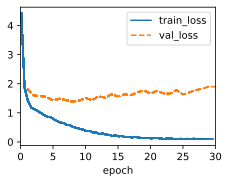

In [30]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [31]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'vais', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


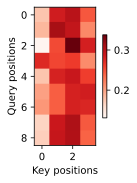

In [32]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')